In [1]:
# Folder holding data, also used for output
data_loc = '/Users/pk/Data/'

In [2]:
import numpy as np
import keras
from keras.datasets import mnist
from keras.models import Sequential, Model
from keras.layers import Dense, Input, Dropout
from keras import optimizers
from keras.optimizers import Adam
import scanpy as sc
import pickle


Using TensorFlow backend.


In [3]:
adata = sc.read(data_loc + 'adata_Luecken_compressed.h5ad')

In [4]:
perc90_cutoff = adata.X.shape[1]*9//10
train_x = adata.X[:perc90_cutoff, :]
test_x = adata.X[perc90_cutoff:, :]

In [5]:
del(adata)

In [6]:
print(train_x.shape)
print(test_x.shape)

(11536, 12818)
(921, 12818)


In [21]:
autoencoder = Sequential()
autoencoder.add(Dense(2048,  activation='elu', input_shape=(train_x.shape[1],)))
autoencoder.add(Dropout(0.25))
autoencoder.add(Dense(512,  activation='relu'))
autoencoder.add(Dropout(0.25))
autoencoder.add(Dense(256,    activation='sigmoid'))
autoencoder.add(Dense(15,    activation='linear', name="bottleneck"))
autoencoder.add(Dense(256,    activation='sigmoid'))
autoencoder.add(Dropout(0.25))
autoencoder.add(Dense(512,  activation='relu'))
autoencoder.add(Dropout(0.25))
autoencoder.add(Dense(2048,  activation='elu'))
autoencoder.add(Dense(train_x.shape[1],  activation='sigmoid'))
autoencoder.compile(loss='mean_squared_error', optimizer = Adam())
trained_model = autoencoder.fit(train_x, train_x, 
                                batch_size=1024, 
                                epochs=3, 
                                verbose=1, 
                                validation_data=(test_x, test_x))
encoder = Model(autoencoder.input, autoencoder.get_layer('bottleneck').output)
encoded_data = encoder.predict(train_x)
print(encoded_data.shape)

Train on 11536 samples, validate on 921 samples
Epoch 1/3
11536/11536 [==============================] - 26s 2ms/step - loss: 0.1388 - val_loss: 0.1035
Epoch 2/3
11536/11536 [==============================] - 26s 2ms/step - loss: 0.1024 - val_loss: 0.1026
Epoch 3/3
11536/11536 [==============================] - 27s 2ms/step - loss: 0.1015 - val_loss: 0.1019
(11536, 15)


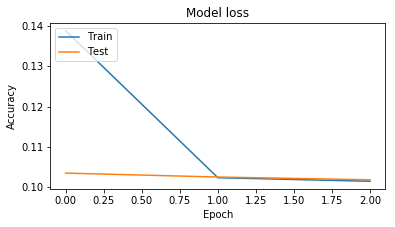

In [23]:
import matplotlib.pyplot as plt
history_dict = trained_model.history
plt.figure()
plt.plot(history_dict['loss'])
plt.plot(history_dict['val_loss'])
plt.subplots_adjust(top=0.7)
plt.title('Model loss')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')

In [24]:
encoded_data = encoder.predict(np.vstack((train_x, test_x)))  # bottleneck representation
print(encoded_data.shape)

(12457, 15)


In [25]:
with open(data_loc + 'autoencoder_Luecken_15.pickle', 'wb') as handle:
    pickle.dump(encoded_data, handle)